In [4]:
import os
# Root directory of the project
ROOT_DIR = os.path.abspath('/kaggle/input/rsna-pneumonia-detection-challenge')

# Directory to save logs and trained model
MODEL_DIR = os.path.abspath('/kaggle/output/kaggle/working')
LOG_DIR = os.path.join(MODEL_DIR, 'logs')
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
os.chdir(MODEL_DIR)

In [5]:
!pwd

/kaggle/output/kaggle/working


In [6]:
import pandas as pd
stage_2_detailed_class_info = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")
stage_2_sample_submission = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv")
stage_2_train_labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [7]:
# variables holding the directory paths to test and train images set
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

In [8]:
import matplotlib.pyplot as plt
import pydicom

testImgPath = os.path.join(ROOT_DIR, 'stage_2_test_images/00330f7f-d114-4eb2-9c6e-558eeb3084a1.dcm')
dataset = pydicom.dcmread(testImgPath)
print(dataset)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29914.1517874494.562398
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00330f7f-d114-4eb2-9c6e-558eeb3084a1'
(0010, 0020) Patient ID                          LO: '00330f7f-d114-4eb2-9c6e-558eeb3084a1'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

Image size.......: 1024 x 1024, 104022 bytes
Pixel spacing....: [0.168, 0.168]
Slice location...: (missing)


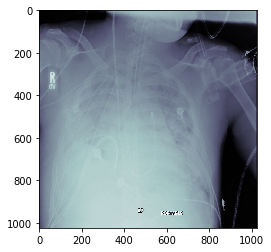

In [9]:
if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

30227 class infos loaded
26684 patient cases


,patientId,class
5149,44a1a8df-9257-43ee-a174-b98ef5d2277b,No Lung Opacity / Not Normal
23550,d42790af-6b5f-47c5-bca6-eab88ae09fa4,Normal
8221,5da671da-84f7-4847-9995-334ecf044f86,Lung Opacity


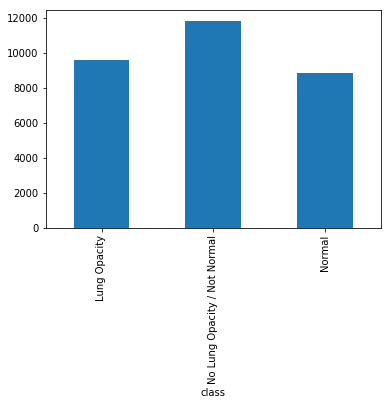

In [10]:
#Divide test images into clear groups and then perform bounding box prediction on the suspicious images
print(stage_2_detailed_class_info.shape[0], 'class infos loaded')
print(stage_2_detailed_class_info['patientId'].value_counts().shape[0], 'patient cases')
stage_2_detailed_class_info.groupby('class').size().plot.bar()
stage_2_detailed_class_info.sample(3)

In [13]:
#concatenate the two datasets (viz. 'stage_2_detailed_class_info' & 'stage_2_train_labels') to get class and target information on each region
comb_bbox_df = pd.concat([stage_2_train_labels, stage_2_detailed_class_info.drop('patientId',1)], 1)
box_df = comb_bbox_df.groupby('patientId').size().reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

30227 combined cases


,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [18]:
#Examine few images having boxes and labels
from glob import glob
image_df = pd.DataFrame({'path': glob(os.path.join(train_dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
image_bbox_df = pd.merge(comb_box_df, image_df, on='patientId', how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

In [16]:
#Visualize sample dataset covering different pneumonia cases and number of bounding boxes corresponding to the same
sample_df = image_bbox_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,4528fe4c-daaa-410b-9089-999bf26ca615,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
1,d7308547-72df-4a22-9387-c1a96c8f8e44,NaN,NaN,NaN,NaN,0,Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
2,726fccb9-cfc1-4a53-b948-460b93073dc2,663.0,368.0,77.0,87.0,1,Lung Opacity,1,/kaggle/input/rsna-pneumonia-detection-challen...
3,dfc1a68e-3314-4059-8a76-4e4e0981a948,132.0,441.0,218.0,245.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
4,dfc1a68e-3314-4059-8a76-4e4e0981a948,600.0,396.0,188.0,263.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
5,7dc00dd4-ad6f-4fee-9e47-3f2b4b88d3ea,231.0,414.0,183.0,242.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
6,7dc00dd4-ad6f-4fee-9e47-3f2b4b88d3ea,756.0,521.0,196.0,101.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
7,7dc00dd4-ad6f-4fee-9e47-3f2b4b88d3ea,642.0,160.0,241.0,345.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
8,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,633.0,128.0,90.0,195.0,1,Lung Opacity,4,/kaggle/input/rsna-pneumonia-detection-challen...
9,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,342.0,157.0,148.0,113.0,1,Lung Opacity,4,/kaggle/input/rsna-pneumonia-detection-challen...


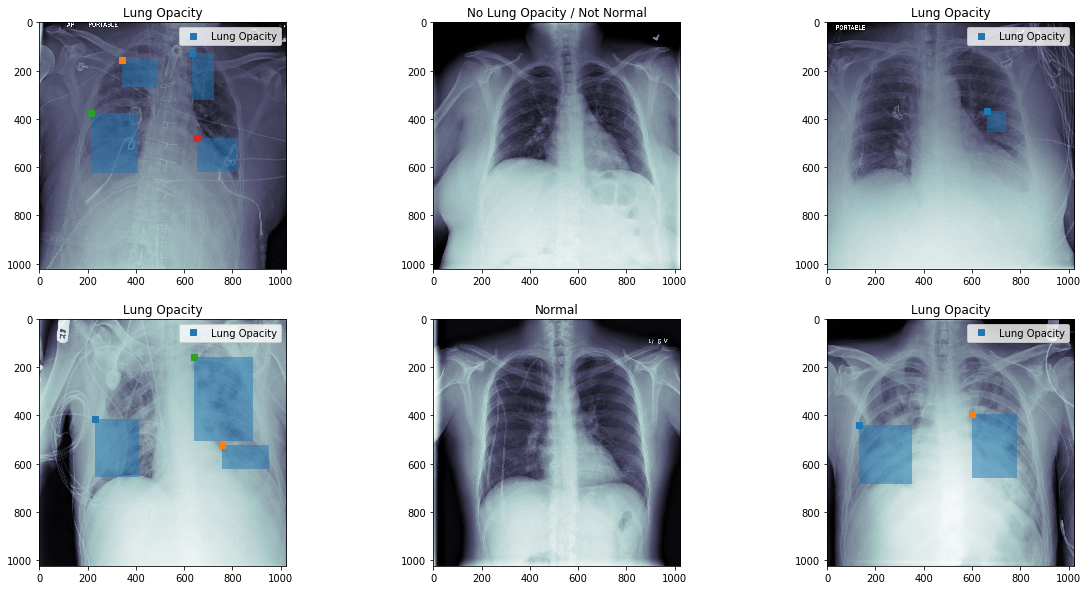

In [17]:
#Visualize the position and bounding box location corresponding to the different pneumonia cases
%matplotlib inline
from matplotlib.patches import Rectangle
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()